## Background

[JuliaDiffEq](https://github.com/JuliaDiffEq) is a suite of optimized Julia libraries to solve ordinary differential equations (ODE). *JuliaDiffEq* provides a large number of explicit and implicit solvers suited for different types of ODE problems. It is possible to reduce a system of partial differential equations into an ODE problem by employing the [method of lines (MOL)](https://en.wikipedia.org/wiki/Method_of_lines). The essence of MOL is to discretize the spatial derivatives (by finite difference, finite volume or finite element methods) into algebraic equations and to keep the time derivatives as is. The resulting differential equations are left with only one independent variable (time) and can be solved with an ODE solver. [Solving Systems of Stochastic PDEs and using GPUs in Julia](http://www.stochasticlifestyle.com/solving-systems-stochastic-pdes-using-gpus-julia/) is a brief introduction to MOL and using GPUs to accelerate PDE solving in *JuliaDiffEq*. Here we expand on this introduction by developing an implicit/explicit (IMEX) solver for a 2D cardiac electrophysiology model and show how to use [CuArray](https://github.com/JuliaGPU/CuArrays.jl) and [CUDAnative](https://github.com/JuliaGPU/CUDAnative.jl) libraries to run the explicit part of the model on a GPU.

Note that this tutorial does not use the [higher order IMEX methods built into DifferentialEquations.jl](http://docs.juliadiffeq.org/latest/solvers/split_ode_solve.html#Implicit-Explicit-(IMEX)-ODE-1) but instead shows how to hand-split an equation when the explicit portion has an analytical solution (or approxiate), which is common in many scenarios.

There are hundreds of ionic models that describe cardiac electrical activity in various degrees of detail. Most are based on the classic [Hodgkin-Huxley model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) and define the time-evolution of different state variables in the form of nonlinear first-order ODEs. The state vector for these models includes the transmembrane potential, gating variables, and ionic concentrations. The coupling between cells is through the transmembrame potential only and is described as a reaction-diffusion equation, which is a parabolic PDE,

$$\partial V / \partial t = \nabla (D  \nabla V) - \frac {I_\text{ion}} {C_m},$$

where $V$ is the transmembrane potential, $D$ is a diffusion tensor, $I_\text{ion}$ is the sum of the transmembrane currents and is calculated from the ODEs, and $C_m$ is the membrane capacitance and is usually assumed to be constant. Here we model a uniform and isotropic medium. Therefore, the model can be simplified to,

$$\partial V / \partial t = D \Delta{V} - \frac {I_\text{ion}} {C_m},$$

where $D$ is now a scalar. By nature, these models have to deal with different time scales and are therefore classified as *stiff*. Commonly, they are solved using the explicit Euler method, usually with a closed form for the integration of the gating variables (the Rush-Larsen method, see below). We can also solve these problems using implicit or semi-implicit PDE solvers (e.g., the [Crank-Nicholson method](https://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method) combined with an iterative solver). Higher order explicit methods such as Runge-Kutta and linear multi-step methods cannot overcome the stiffness and are not particularly helpful.

In this tutorial, we first develop a CPU-only IMEX solver and then show how to move the explicit part to a GPU.

### The Beeler-Reuter Model

We have chosen the [Beeler-Reuter ventricular ionic model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1283659/) as our example. It is a classic model first described in 1977 and is used as a base for many other ionic models. It has eight state variables, which makes it complicated enough to be interesting without obscuring the main points of the exercise. The eight state variables are: the transmembrane potential ($V$), sodium-channel activation and inactivation gates ($m$ and $h$, similar to the Hodgkin-Huxley model), with an additional slow inactivation gate ($j$), calcium-channel activation and deactivations gates ($d$ and $f$), a time-dependent inward-rectifying potassium current gate ($x_1$), and intracellular calcium concentration ($c$). There are four currents: a sodium current ($i_{Na}$), a calcium current ($i_{Ca}$), and two potassium currents, one time-dependent ($i_{x_1}$) and one background time-independent ($i_{K_1}$).

## CPU-Only Beeler-Reuter Solver

Let's start by developing a CPU only IMEX solver. The main idea is to use the *DifferentialEquations* framework to handle the implicit part of the equation and code the analytical approximation for explicit part separately. If no analytical approximation was known for the explicit part, one could use methods from [this list](http://docs.juliadiffeq.org/latest/solvers/split_ode_solve.html#Implicit-Explicit-(IMEX)-ODE-1).

First, we define the model constants:
# An Implicit&#x2F;Explicit CUDA-Accelerated Solver for the 2D Beeler-Reuter Model
### Shahriar Iravanian

In [1]:
const v0 = -84.624
const v1 = 10.0
const C_K1 = 1.0f0
const C_x1 = 1.0f0
const C_Na = 1.0f0
const C_s = 1.0f0
const D_Ca = 0.0f0
const D_Na = 0.0f0
const g_s = 0.09f0
const g_Na = 4.0f0
const g_NaC = 0.005f0
const ENa = 50.0f0 + D_Na
const γ = 0.5f0
const C_m = 1.0f0

1.0f0

Note that the constants are defined as `Float32` and not `Float64`. The reason is that most GPUs have many more single precision cores than double precision ones. To ensure uniformity between CPU and GPU, we also code most states variables as `Float32` except for the transmembrane potential, which is solved by an implicit solver provided by the Sundial library and needs to be `Float64`.

### The State Structure

Next, we define a struct to contain our state. `BeelerReuterCpu` is a functor and we will define a deriv function as its associated function.

In [2]:
mutable struct BeelerReuterCpu <: Function
    t::Float64              # the last timestep time to calculate Δt
    diff_coef::Float64      # the diffusion-coefficient (coupling strength)

    C::Array{Float32, 2}    # intracellular calcium concentration
    M::Array{Float32, 2}    # sodium current activation gate (m)
    H::Array{Float32, 2}    # sodium current inactivation gate (h)
    J::Array{Float32, 2}    # sodium current slow inactivaiton gate (j)
    D::Array{Float32, 2}    # calcium current activaiton gate (d)
    F::Array{Float32, 2}    # calcium current inactivation gate (f)
    XI::Array{Float32, 2}   # inward-rectifying potassium current (iK1)

    Δu::Array{Float64, 2}   # place-holder for the Laplacian

    function BeelerReuterCpu(u0, diff_coef)
        self = new()

        ny, nx = size(u0)
        self.t = 0.0
        self.diff_coef = diff_coef

        self.C = fill(0.0001f0, (ny,nx))
        self.M = fill(0.01f0, (ny,nx))
        self.H = fill(0.988f0, (ny,nx))
        self.J = fill(0.975f0, (ny,nx))
        self.D = fill(0.003f0, (ny,nx))
        self.F = fill(0.994f0, (ny,nx))
        self.XI = fill(0.0001f0, (ny,nx))

        self.Δu = zeros(ny,nx)

        return self
    end
end

### Laplacian

The finite-difference Laplacian is calculated in-place by a 5-point stencil. The Neumann boundary condition is enforced. Note that we could have also used [DiffEqOperators.jl](https://github.com/JuliaDiffEq/DiffEqOperators.jl) to automate this step.

In [3]:
# 5-point stencil
function laplacian(Δu, u)
    n1, n2 = size(u)

    # internal nodes
    for j = 2:n2-1
        for i = 2:n1-1
            @inbounds  Δu[i,j] = u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] - 4*u[i,j]
        end
    end

    # left/right edges
    for i = 2:n1-1
        @inbounds Δu[i,1] = u[i+1,1] + u[i-1,1] + 2*u[i,2] - 4*u[i,1]
        @inbounds Δu[i,n2] = u[i+1,n2] + u[i-1,n2] + 2*u[i,n2-1] - 4*u[i,n2]
    end

    # top/bottom edges
    for j = 2:n2-1
        @inbounds Δu[1,j] = u[1,j+1] + u[1,j-1] + 2*u[2,j] - 4*u[1,j]
        @inbounds Δu[n1,j] = u[n1,j+1] + u[n1,j-1] + 2*u[n1-1,j] - 4*u[n1,j]
    end

    # corners
    @inbounds Δu[1,1] = 2*(u[2,1] + u[1,2]) - 4*u[1,1]
    @inbounds Δu[n1,1] = 2*(u[n1-1,1] + u[n1,2]) - 4*u[n1,1]
    @inbounds Δu[1,n2] = 2*(u[2,n2] + u[1,n2-1]) - 4*u[1,n2]
    @inbounds Δu[n1,n2] = 2*(u[n1-1,n2] + u[n1,n2-1]) - 4*u[n1,n2]
end

laplacian (generic function with 1 method)

### The Rush-Larsen Method

We use an explicit solver for all the state variables except for the transmembrane potential which is solved with the help of an implicit solver. The explicit solver is a domain-specific exponential method, the Rush-Larsen method. This method utilizes an approximation on the model in order to transform the IMEX equation into a form suitable for an implicit ODE solver. This combination of implicit and explicit methods forms a specialized IMEX solver. For general IMEX integration, please see the [IMEX solvers documentation](http://docs.juliadiffeq.org/latest/solvers/split_ode_solve.html#Implicit-Explicit-%28IMEX%29-ODE-1). While we could have used the general model to solve the current problem, for this specific model, the transformation approach is more efficient and is of practical interest.

The [Rush-Larsen](https://ieeexplore.ieee.org/document/4122859/) method replaces the explicit Euler integration for the gating variables with direct integration. The starting point is the general ODE for the gating variables in Hodgkin-Huxley style ODEs,

$$\frac{dg}{dt} = \alpha(V) (1 - g) - \beta(V) g$$

where $g$ is a generic gating variable, ranging from 0 to 1, and $\alpha$ and $\beta$ are reaction rates. This equation can be written as,

$$\frac{dg}{dt} = (g_{\infty} - g) / \tau_g,$$

where $g_\infty$ and $\tau_g$ are

$$g_{\infty} = \frac{\alpha}{(\alpha + \beta)},$$

and,

$$\tau_g = \frac{1}{(\alpha + \beta)}.$$

Assuing that $g_\infty$ and $\tau_g$ are constant for the duration of a single time step ($\Delta{t}$), which is a reasonable assumption for most cardiac models, we can integrate directly to have,

$$g(t + \Delta{t}) = g_{\infty} - \left(g_{\infty} - g(\Delta{t})\right)\,e^{-\Delta{t}/\tau_g}.$$

This is the Rush-Larsen technique. Note that as $\Delta{t} \rightarrow 0$, this equations morphs into the explicit Euler formula,

$$g(t + \Delta{t}) = g(t) + \Delta{t}\frac{dg}{dt}.$$

`rush_larsen` is a helper function that use the Rush-Larsen method to integrate the gating variables.

In [4]:
@inline function rush_larsen(g, α, β, Δt)
    inf = α/(α+β)
    τ = 1f0 / (α+β)
    return clamp(g + (g - inf) * expm1(-Δt/τ), 0f0, 1f0)
end

rush_larsen (generic function with 1 method)

The gating variables are updated as below. The details of how to calculate $\alpha$ and $\beta$ are based on the Beeler-Reuter model and not of direct interest to this tutorial.

In [5]:
function update_M_cpu(g, v, Δt)
    # the condition is needed here to prevent NaN when v == 47.0
    α = isapprox(v, 47.0f0) ? 10.0f0 : -(v+47.0f0) / (exp(-0.1f0*(v+47.0f0)) - 1.0f0)
    β = (40.0f0 * exp(-0.056f0*(v+72.0f0)))
    return rush_larsen(g, α, β, Δt)
end

function update_H_cpu(g, v, Δt)
    α = 0.126f0 * exp(-0.25f0*(v+77.0f0))
    β = 1.7f0 / (exp(-0.082f0*(v+22.5f0)) + 1.0f0)
   return rush_larsen(g, α, β, Δt)
end

function update_J_cpu(g, v, Δt)
    α = (0.55f0 * exp(-0.25f0*(v+78.0f0))) / (exp(-0.2f0*(v+78.0f0)) + 1.0f0)
    β = 0.3f0 / (exp(-0.1f0*(v+32.0f0)) + 1.0f0)
    return rush_larsen(g, α, β, Δt)
end

function update_D_cpu(g, v, Δt)
    α = γ * (0.095f0 * exp(-0.01f0*(v-5.0f0))) / (exp(-0.072f0*(v-5.0f0)) + 1.0f0)
    β = γ * (0.07f0 * exp(-0.017f0*(v+44.0f0))) / (exp(0.05f0*(v+44.0f0)) + 1.0f0)
    return rush_larsen(g, α, β, Δt)
end

function update_F_cpu(g, v, Δt)
    α = γ * (0.012f0 * exp(-0.008f0*(v+28.0f0))) / (exp(0.15f0*(v+28.0f0)) + 1.0f0)
    β = γ * (0.0065f0 * exp(-0.02f0*(v+30.0f0))) / (exp(-0.2f0*(v+30.0f0)) + 1.0f0)
    return rush_larsen(g, α, β, Δt)
end

function update_XI_cpu(g, v, Δt)
    α = (0.0005f0 * exp(0.083f0*(v+50.0f0))) / (exp(0.057f0*(v+50.0f0)) + 1.0f0)
    β = (0.0013f0 * exp(-0.06f0*(v+20.0f0))) / (exp(-0.04f0*(v+20.0f0)) + 1.0f0)
    return rush_larsen(g, α, β, Δt)
end

update_XI_cpu (generic function with 1 method)

The intracelleular calcium is not technically a gating variable, but we can use a similar explicit exponential integrator for it.

In [6]:
function update_C_cpu(g, d, f, v, Δt)
    ECa = D_Ca - 82.3f0 - 13.0278f0 * log(g)
    kCa = C_s * g_s * d * f
    iCa = kCa * (v - ECa)
    inf = 1.0f-7 * (0.07f0 - g)
    τ = 1f0 / 0.07f0
    return g + (g - inf) * expm1(-Δt/τ)
end

update_C_cpu (generic function with 1 method)

### Implicit Solver

Now, it is time to define the derivative function as an associated function of **BeelerReuterCpu**. We plan to use the CVODE_BDF solver as our implicit portion. Similar to other iterative methods, it calls the deriv function with the same $t$ multiple times. For example, these are consecutive $t$s from a representative run:

0.86830
0.86830
0.85485
0.85485
0.85485
0.86359
0.86359
0.86359
0.87233
0.87233
0.87233
0.88598
...

Here, every time step is called three times. We distinguish between two types of calls to the deriv function. When $t$ changes, the gating variables are updated by calling `update_gates_cpu`:

In [7]:
function update_gates_cpu(u, XI, M, H, J, D, F, C, Δt)
    let Δt = Float32(Δt)
        n1, n2 = size(u)
        for j = 1:n2
            for i = 1:n1
                v = Float32(u[i,j])

                XI[i,j] = update_XI_cpu(XI[i,j], v, Δt)
                M[i,j] = update_M_cpu(M[i,j], v, Δt)
                H[i,j] = update_H_cpu(H[i,j], v, Δt)
                J[i,j] = update_J_cpu(J[i,j], v, Δt)
                D[i,j] = update_D_cpu(D[i,j], v, Δt)
                F[i,j] = update_F_cpu(F[i,j], v, Δt)

                C[i,j] = update_C_cpu(C[i,j], D[i,j], F[i,j], v, Δt)
            end
        end
    end
end

update_gates_cpu (generic function with 1 method)

On the other hand, du is updated at each time step, since it is independent of $\Delta{t}$.

In [8]:
# iK1 is the inward-rectifying potassium current
function calc_iK1(v)
    ea = exp(0.04f0*(v+85f0))
    eb = exp(0.08f0*(v+53f0))
    ec = exp(0.04f0*(v+53f0))
    ed = exp(-0.04f0*(v+23f0))
    return 0.35f0 * (4f0*(ea-1f0)/(eb + ec)
            + 0.2f0 * (isapprox(v, -23f0) ? 25f0 : (v+23f0) / (1f0-ed)))
end

# ix1 is the time-independent background potassium current
function calc_ix1(v, xi)
    ea = exp(0.04f0*(v+77f0))
    eb = exp(0.04f0*(v+35f0))
    return xi * 0.8f0 * (ea-1f0) / eb
end

# iNa is the sodium current (similar to the classic Hodgkin-Huxley model)
function calc_iNa(v, m, h, j)
    return C_Na * (g_Na * m^3 * h * j + g_NaC) * (v - ENa)
end

# iCa is the calcium current
function calc_iCa(v, d, f, c)
    ECa = D_Ca - 82.3f0 - 13.0278f0 * log(c)    # ECa is the calcium reversal potential
    return C_s * g_s * d * f * (v - ECa)
end

function update_du_cpu(du, u, XI, M, H, J, D, F, C)
    n1, n2 = size(u)

    for j = 1:n2
        for i = 1:n1
            v = Float32(u[i,j])

            # calculating individual currents
            iK1 = calc_iK1(v)
            ix1 = calc_ix1(v, XI[i,j])
            iNa = calc_iNa(v, M[i,j], H[i,j], J[i,j])
            iCa = calc_iCa(v, D[i,j], F[i,j], C[i,j])

            # total current
            I_sum = iK1 + ix1 + iNa + iCa

            # the reaction part of the reaction-diffusion equation
            du[i,j] = -I_sum / C_m
        end
    end
end

update_du_cpu (generic function with 1 method)

Finally, we put everything together is our deriv function, which is a call on `BeelerReuterCpu`.

In [10]:
function (f::BeelerReuterCpu)(du, u, p, t)
    Δt = t - f.t

    if Δt != 0 || t == 0
        update_gates_cpu(u, f.XI, f.M, f.H, f.J, f.D, f.F, f.C, Δt)
        f.t = t
    end

    laplacian(f.Δu, u)

    # calculate the reaction portion
    update_du_cpu(du, u, f.XI, f.M, f.H, f.J, f.D, f.F, f.C)

    # ...add the diffusion portion
    du .+= f.diff_coef .* f.Δu
end

### Results

Time to test! We need to define the starting transmembrane potential with the help of global constants **v0** and **v1**, which represent the resting and activated potentials.

In [11]:
const N = 192;
u0 = fill(v0, (N, N));
u0[90:102,90:102] .= v1;   # a small square in the middle of the domain

The initial condition is a small square in the middle of the domain.

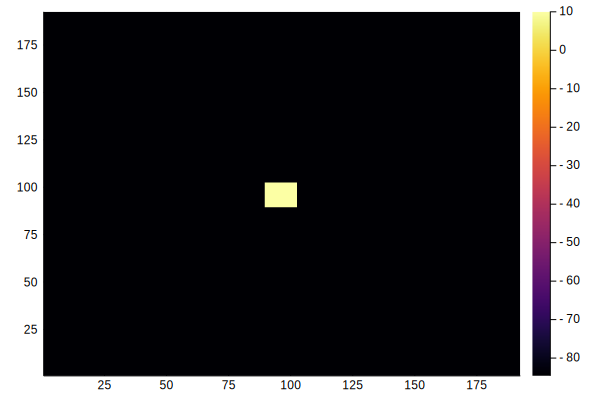

In [12]:
using Plots
heatmap(u0)

Next, the problem is defined:

In [13]:
using DifferentialEquations, Sundials

deriv_cpu = BeelerReuterCpu(u0, 1.0);
prob = ODEProblem(deriv_cpu, u0, (0.0, 50.0));

For stiff reaction-diffusion equations, CVODE_BDF from Sundial library is an excellent solver.

In [14]:
@time sol = solve(prob, CVODE_BDF(linear_solver=:GMRES), saveat=100.0);

 34.647556 seconds (6.08 M allocations: 317.245 MiB, 0.32% gc time)


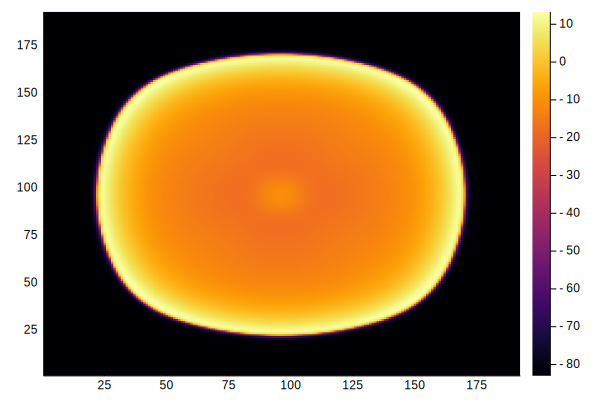

In [15]:
heatmap(sol.u[end])

## CPU/GPU Beeler-Reuter Solver

GPUs are great for embarrassingly parallel problems but not so much for highly coupled models. We plan to keep the implicit part on CPU and run the decoupled explicit code on a GPU with the help of the CUDAnative library.

### GPUs and CUDA

It this section, we present a brief summary of how GPUs (specifically NVIDIA GPUs) work and how to program them using the Julia CUDA interface. The readers who are familiar with these basic concepts may skip this section.

Let's start by looking at the hardware of a typical high-end GPU, GTX 1080. It has four Graphics Processing Clusters (equivalent to a discrete CPU), each harboring five Streaming Multiprocessor (similar to a CPU core). Each SM has 128 single-precision CUDA cores. Therefore, GTX 1080 has a total of 4 x 5 x 128 = 2560 CUDA cores. The maximum  theoretical throughput for a GTX 1080 is reported as 8.87 TFLOPS. This figure is calculated for a boost clock frequency of 1.733 MHz as 2 x 2560 x 1.733 MHz = 8.87 TFLOPS. The factor 2 is included because two single floating point operations, a multiplication and an addition, can be done in a clock cycle as part of a fused-multiply-addition FMA operation. GTX 1080 also has 8192 MB of global memory accessible to all the cores (in addition to local and shared memory on each SM).

A typical CUDA application has the following flow:

1. Define and initialize the problem domain tensors (multi-dimensional arrays) in CPU memory.
2. Allocate corresponding tensors in the GPU global memory.
3. Transfer the input tensors from CPU to the corresponding GPU tensors.
4. Invoke CUDA kernels (i.e., the GPU functions callable from CPU) that operate on the GPU tensors.
5. Transfer the result tensors from GPU back to CPU.
6. Process tensors on CPU.
7. Repeat steps 3-6 as needed.

Some libraries, such as [ArrayFire](https://github.com/arrayfire/arrayfire), hide the complexicities of steps 2-5 behind a higher level of abstraction. However, here we take a lower level route. By using [CuArray](https://github.com/JuliaGPU/CuArrays.jl) and [CUDAnative](https://github.com/JuliaGPU/CUDAnative.jl), we achieve a finer-grained control and higher performance. In return, we need to implement each step manually.

*CuArray* is a thin abstraction layer over the CUDA API and allows us to define GPU-side tensors and copy data to and from them but does not provide for operations on tensors. *CUDAnative* is a compiler that translates Julia functions designated as CUDA kernels into ptx (a high-level CUDA assembly language).

### The CUDA Code

The key to fast CUDA programs is to minimize CPU/GPU memory transfers and global memory accesses. The implicit solver is currently CPU only, but it only needs access to the transmembrane potential. The rest of state variables reside on the GPU memory.

We modify ``BeelerReuterCpu`` into ``BeelerReuterGpu`` by defining the state variables as *CuArray*s instead of standard Julia *Array*s. The name of each variable defined on GPU is prefixed by *d_* for clarity. Note that $\Delta{v}$ is a temporary storage for the Laplacian and stays on the CPU side.

In [19]:
using CUDAnative, CuArrays

mutable struct BeelerReuterGpu <: Function
    t::Float64                  # the last timestep time to calculate Δt
    diff_coef::Float64          # the diffusion-coefficient (coupling strength)

    d_C::CuArray{Float32, 2}    # intracellular calcium concentration
    d_M::CuArray{Float32, 2}    # sodium current activation gate (m)
    d_H::CuArray{Float32, 2}    # sodium current inactivation gate (h)
    d_J::CuArray{Float32, 2}    # sodium current slow inactivaiton gate (j)
    d_D::CuArray{Float32, 2}    # calcium current activaiton gate (d)
    d_F::CuArray{Float32, 2}    # calcium current inactivation gate (f)
    d_XI::CuArray{Float32, 2}   # inward-rectifying potassium current (iK1)

    d_u::CuArray{Float64, 2}    # place-holder for u in the device memory
    d_du::CuArray{Float64, 2}   # place-holder for d_u in the device memory

    Δv::Array{Float64, 2}       # place-holder for voltage gradient

    function BeelerReuterGpu(u0, diff_coef)
        self = new()

        ny, nx = size(u0)
        @assert (nx % 16 == 0) && (ny % 16 == 0)
        self.t = 0.0
        self.diff_coef = diff_coef

        self.d_C = CuArray(fill(0.0001f0, (ny,nx)))
        self.d_M = CuArray(fill(0.01f0, (ny,nx)))
        self.d_H = CuArray(fill(0.988f0, (ny,nx)))
        self.d_J = CuArray(fill(0.975f0, (ny,nx)))
        self.d_D = CuArray(fill(0.003f0, (ny,nx)))
        self.d_F = CuArray(fill(0.994f0, (ny,nx)))
        self.d_XI = CuArray(fill(0.0001f0, (ny,nx)))

        self.d_u = CuArray(u0)
        self.d_du = CuArray(zeros(ny,nx))

        self.Δv = zeros(ny,nx)

        return self
    end
end

The Laplacian function remains unchanged. The main change to the explicit gating solvers is that *exp* and *expm1* functions are prefixed by *CUDAnative.*. This is a technical nuisance that will hopefully be resolved in future.

In [20]:
function rush_larsen_gpu(g, α, β, Δt)
    inf = α/(α+β)
    τ = 1.0/(α+β)
    return clamp(g + (g - inf) * CUDAnative.expm1(-Δt/τ), 0f0, 1f0)
end

function update_M_gpu(g, v, Δt)
    # the condition is needed here to prevent NaN when v == 47.0
    α = isapprox(v, 47.0f0) ? 10.0f0 : -(v+47.0f0) / (CUDAnative.exp(-0.1f0*(v+47.0f0)) - 1.0f0)
    β = (40.0f0 * CUDAnative.exp(-0.056f0*(v+72.0f0)))
    return rush_larsen_gpu(g, α, β, Δt)
end

function update_H_gpu(g, v, Δt)
    α = 0.126f0 * CUDAnative.exp(-0.25f0*(v+77.0f0))
    β = 1.7f0 / (CUDAnative.exp(-0.082f0*(v+22.5f0)) + 1.0f0)
    return rush_larsen_gpu(g, α, β, Δt)
end

function update_J_gpu(g, v, Δt)
    α = (0.55f0 * CUDAnative.exp(-0.25f0*(v+78.0f0))) / (CUDAnative.exp(-0.2f0*(v+78.0f0)) + 1.0f0)
    β = 0.3f0 / (CUDAnative.exp(-0.1f0*(v+32.0f0)) + 1.0f0)
    return rush_larsen_gpu(g, α, β, Δt)
end

function update_D_gpu(g, v, Δt)
    α = γ * (0.095f0 * CUDAnative.exp(-0.01f0*(v-5.0f0))) / (CUDAnative.exp(-0.072f0*(v-5.0f0)) + 1.0f0)
    β = γ * (0.07f0 * CUDAnative.exp(-0.017f0*(v+44.0f0))) / (CUDAnative.exp(0.05f0*(v+44.0f0)) + 1.0f0)
    return rush_larsen_gpu(g, α, β, Δt)
end

function update_F_gpu(g, v, Δt)
    α = γ * (0.012f0 * CUDAnative.exp(-0.008f0*(v+28.0f0))) / (CUDAnative.exp(0.15f0*(v+28.0f0)) + 1.0f0)
    β = γ * (0.0065f0 * CUDAnative.exp(-0.02f0*(v+30.0f0))) / (CUDAnative.exp(-0.2f0*(v+30.0f0)) + 1.0f0)
    return rush_larsen_gpu(g, α, β, Δt)
end

function update_XI_gpu(g, v, Δt)
    α = (0.0005f0 * CUDAnative.exp(0.083f0*(v+50.0f0))) / (CUDAnative.exp(0.057f0*(v+50.0f0)) + 1.0f0)
    β = (0.0013f0 * CUDAnative.exp(-0.06f0*(v+20.0f0))) / (CUDAnative.exp(-0.04f0*(v+20.0f0)) + 1.0f0)
    return rush_larsen_gpu(g, α, β, Δt)
end

function update_C_gpu(c, d, f, v, Δt)
    ECa = D_Ca - 82.3f0 - 13.0278f0 * CUDAnative.log(c)
    kCa = C_s * g_s * d * f
    iCa = kCa * (v - ECa)
    inf = 1.0f-7 * (0.07f0 - c)
    τ = 1f0 / 0.07f0
    return c + (c - inf) * CUDAnative.expm1(-Δt/τ)
end

update_C_gpu (generic function with 1 method)

Similarly, we modify the functions to calculate the individual currents by adding CUDAnative prefix.

In [21]:
# iK1 is the inward-rectifying potassium current
function calc_iK1(v)
    ea = CUDAnative.exp(0.04f0*(v+85f0))
    eb = CUDAnative.exp(0.08f0*(v+53f0))
    ec = CUDAnative.exp(0.04f0*(v+53f0))
    ed = CUDAnative.exp(-0.04f0*(v+23f0))
    return 0.35f0 * (4f0*(ea-1f0)/(eb + ec)
            + 0.2f0 * (isapprox(v, -23f0) ? 25f0 : (v+23f0) / (1f0-ed)))
end

# ix1 is the time-independent background potassium current
function calc_ix1(v, xi)
    ea = CUDAnative.exp(0.04f0*(v+77f0))
    eb = CUDAnative.exp(0.04f0*(v+35f0))
    return xi * 0.8f0 * (ea-1f0) / eb
end

# iNa is the sodium current (similar to the classic Hodgkin-Huxley model)
function calc_iNa(v, m, h, j)
    return C_Na * (g_Na * m^3 * h * j + g_NaC) * (v - ENa)
end

# iCa is the calcium current
function calc_iCa(v, d, f, c)
    ECa = D_Ca - 82.3f0 - 13.0278f0 * CUDAnative.log(c)    # ECa is the calcium reversal potential
    return C_s * g_s * d * f * (v - ECa)
end

calc_iCa (generic function with 1 method)

### CUDA Kernels

A CUDA program does not directly deal with GPCs and SMs. The logical view of a CUDA program is in the term of *blocks* and *threads*. We have to specify the number of block and threads when running a CUDA *kernel*. Each thread runs on a single CUDA core. Threads are logically bundled into blocks, which are in turn specified on a grid. The grid stands for the entirety of the domain of interest.

Each thread can find its logical coordinate by using few pre-defined indexing variables (*threadIdx*, *blockIdx*, *blockDim* and *gridDim*) in C/C++ and the corresponding functions (e.g., `threadIdx()`) in Julia. There variables and functions are defined automatically for each thread and may return a different value depending on the calling thread. The return value of these functions is a 1, 2, or 3 dimensional structure whose elements can be accessed as `.x`, `.y`, and `.z` (for a 1-dimensional case, `.x` reports the actual index and `.y` and `.z` simply return 1). For example, if we deploy a kernel in 128 blocks and with 256 threads per block, each thread will see

```
    gridDim.x = 128;
    blockDim=256;
```

while `blockIdx.x` ranges from 0 to 127 in C/C++ and 1 to 128 in Julia. Similarly, `threadIdx.x` will be between 0 to 255 in C/C++ (of course, in Julia the range will be 1 to 256).

A C/C++ thread can calculate its index as

```
    int idx = blockDim.x * blockIdx.x + threadIdx.x;
```

In Julia, we have to take into account base 1. Therefore, we use the following formula

```
    idx = (blockIdx().x-UInt32(1)) * blockDim().x + threadIdx().x
```

A CUDA programmer is free to interpret the calculated index however it fits the application, but in practice, it is usually interpreted as an index into input tensors.

In the GPU version of the solver, each thread works on a single element of the medium, indexed by a (x,y) pair.
`update_gates_gpu` and `update_du_gpu` are very similar to their CPU counterparts but are in fact CUDA kernels where the *for* loops are replaced with CUDA specific indexing. Note that CUDA kernels cannot return a valve; hence, *nothing* at the end.

In [22]:
function update_gates_gpu(u, XI, M, H, J, D, F, C, Δt)
    i = (blockIdx().x-UInt32(1)) * blockDim().x + threadIdx().x
    j = (blockIdx().y-UInt32(1)) * blockDim().y + threadIdx().y

    v = Float32(u[i,j])

    let Δt = Float32(Δt)
        XI[i,j] = update_XI_gpu(XI[i,j], v, Δt)
        M[i,j] = update_M_gpu(M[i,j], v, Δt)
        H[i,j] = update_H_gpu(H[i,j], v, Δt)
        J[i,j] = update_J_gpu(J[i,j], v, Δt)
        D[i,j] = update_D_gpu(D[i,j], v, Δt)
        F[i,j] = update_F_gpu(F[i,j], v, Δt)

        C[i,j] = update_C_gpu(C[i,j], D[i,j], F[i,j], v, Δt)
    end
    nothing
end

function update_du_gpu(du, u, XI, M, H, J, D, F, C)
    i = (blockIdx().x-UInt32(1)) * blockDim().x + threadIdx().x
    j = (blockIdx().y-UInt32(1)) * blockDim().y + threadIdx().y

    v = Float32(u[i,j])

    # calculating individual currents
    iK1 = calc_iK1(v)
    ix1 = calc_ix1(v, XI[i,j])
    iNa = calc_iNa(v, M[i,j], H[i,j], J[i,j])
    iCa = calc_iCa(v, D[i,j], F[i,j], C[i,j])

    # total current
    I_sum = iK1 + ix1 + iNa + iCa

    # the reaction part of the reaction-diffusion equation
    du[i,j] = -I_sum / C_m
    nothing
end

update_du_gpu (generic function with 1 method)

### Implicit Solver

Finally, the deriv function is modified to copy *u* to GPU and copy *du* back and to invoke CUDA kernels.

In [23]:
function (f::BeelerReuterGpu)(du, u, p, t)
    L = 16   # block size
    Δt = t - f.t
    copyto!(f.d_u, u)
    ny, nx = size(u)

    if Δt != 0 || t == 0
        @cuda blocks=(ny÷L,nx÷L) threads=(L,L) update_gates_gpu(
            f.d_u, f.d_XI, f.d_M, f.d_H, f.d_J, f.d_D, f.d_F, f.d_C, Δt)
        f.t = t
    end

    laplacian(f.Δv, u)

    # calculate the reaction portion
    @cuda blocks=(ny÷L,nx÷L) threads=(L,L) update_du_gpu(
        f.d_du, f.d_u, f.d_XI, f.d_M, f.d_H, f.d_J, f.d_D, f.d_F, f.d_C)

    copyto!(du, f.d_du)

    # ...add the diffusion portion
    du .+= f.diff_coef .* f.Δv
end

Ready to test!

In [27]:
using DifferentialEquations, Sundials

deriv_gpu = BeelerReuterGpu(u0, 1.0);
prob = ODEProblem(deriv_gpu, u0, (0.0, 50.0));
@time sol = solve(prob, CVODE_BDF(linear_solver=:GMRES), saveat=100.0);

  7.295265 seconds (289.48 k allocations: 1.563 GiB, 2.25% gc time)


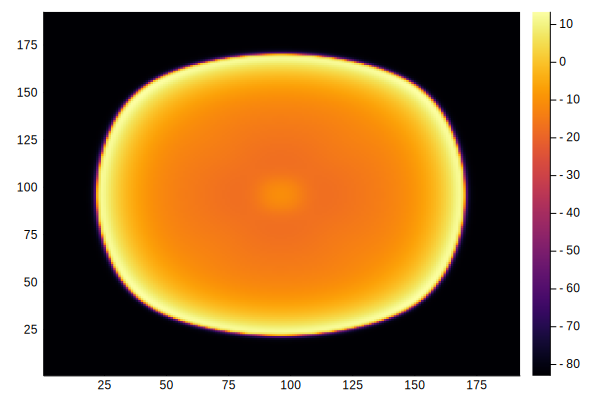

In [25]:
heatmap(sol.u[end])

## Summary

We achieve around a 6x speedup with running the explicit portion of our IMEX solver on a GPU. The major bottleneck of this technique is the communication between CPU and GPU. In its current form, not all of the internals of the method utilize GPU acceleration. In particular, the implicit equations solved by GMRES are performed on the CPU. This partial CPU nature also increases the amount of data transfer that is required between the GPU and CPU (performed every f call). Compiling the full ODE solver to the GPU would solve both of these issues and potentially give a much larger speedup. [JuliaDiffEq developers are currently working on solutions to alleviate these issues](http://www.stochasticlifestyle.com/solving-systems-stochastic-pdes-using-gpus-julia/), but these will only be compatible with native Julia solvers (and not Sundials).